In [1]:
! pip install pyswarms==0.2.0

In [2]:
import sys
sys.path.append('../')
#code below used to deal with special characters on the file path during read_csv()
# sys._enablelegacywindowsfsencoding() 

In [3]:
# Import modules
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt #MatPlotLib usado para desenhar o gráfico criado com o NetworkX

# Import PySwarms
import pyswarms as ps

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=450, n_features=80, n_classes=2, 
                           n_informative=50, n_redundant=0, n_repeated=0, 
                           random_state=None, shuffle=True)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, random_state=None)
# X, y = make_classification(n_samples=100, n_features=15, n_classes=3,
#                           n_informative=4, n_redundant=1, n_repeated=2,
#                           random_state=1)

In [5]:
X.shape

(360, 80)

In [6]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = linear_model.LogisticRegression()
#classifier = RandomForestClassifier(n_estimators = 64,
#                                    #max_features = 30,
#                                    bootstrap = True,
#                                    random_state = None)
    
#clf = forest
#clf.fit(X_trainOhFeatures, y_train)
#predictions = clf.predict(X_testOhFeatures)
#accuracy = accuracy_score(y_test, predictions)


# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    total_features = X.shape[1]
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0: 
        #if the particle subset is only zeros, get the original set of attributes
        X_subset = X
    else:
        X_subset = X[:,m==1]
        
    #X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.20, random_state=None)
    # Perform classification and store performance in P
    #classifier.fit(X_train, y_train)
    #P = (classifier.predict(X_test) == y_test).mean()
    
    scores = cross_val_score(classifier, X_subset, y, cv=3)
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    P = scores.mean()
    particleScore.append(P)
    particleSize.append(X_subset.shape[1])
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    
    #j = (alpha * (1.0 - P)) + (1 - alpha) * (1 - (total_features - X_subset.shape[1]) / total_features)
    #print("Particle j: ", j)
    return j

In [7]:
def f(x, alpha=0.9):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    #print("f j: ", j)
    return np.array(j)

Started at:  2021-02-17 14:06:31.461428


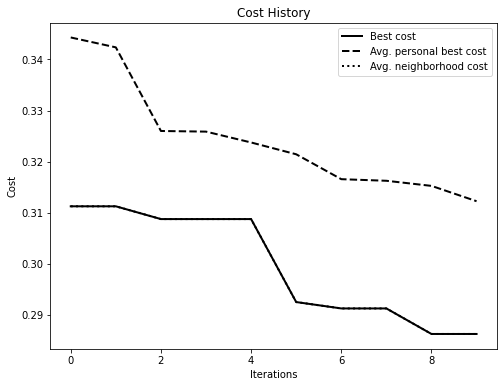

Finished at:  2021-02-17 14:06:47.024989
Total time spent:  0:00:15.563561


In [8]:
from datetime import datetime as dt
import time
from pyswarms.utils.environments import PlotEnvironment

start = dt.now()
print("Started at: ", str(start))
particleScore = list()
particleSize = list()
#mySubsets = list()

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.3, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X.shape[1] # dimensions should be the number of features
# optimizer.reset()
#optimizer = ps.single.GlobalBestPSO(n_particles=1, dimensions=dimensions,
#                                    options=options)
optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
# cost, pos = optimizer.optimize(f, print_step=1, iters=10, verbose=2)


# Initialize plot environment
plt_env = PlotEnvironment(optimizer, f, 10)

# Plot the cost
plt_env.plot_cost(figsize=(8,6));
plt.show()


# print(cost,pos)
end = dt.now()
print("Finished at: ", str(end))
total = end-start
print("Total time spent: ", total)

In [9]:
print(optimizer.get_mean_pbest_history)
print(optimizer.swarm.pbest_pos[5])

#mean_pbest_history

#optimizer.get_pos_history
#optimizer.get_velocity_history
#optimizer.pos_history #subsets of attributes [iters[particles]]


[0.3443125 0.342375  0.326     0.325875  0.32375   0.3214375 0.3165625
 0.31625   0.31525   0.31225  ]
[0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1
 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1
 1 0 1 1 1 1]


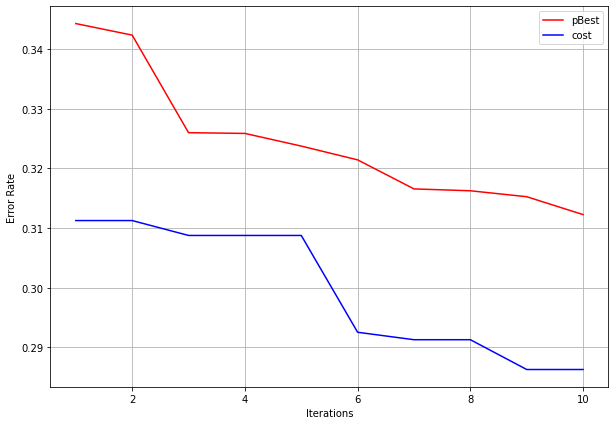

In [10]:
iterations = list(range(1,len(optimizer.get_cost_history)+1))
plt.figure(figsize=(10,7))
#plt.xlabel('2^i classes')
plt.xlabel('Iterations')
plt.ylabel('Error Rate')
#get_cost_history #erro médio da iteracao
#optimizer.mean_pbest_history #erro minimo pbest
plt.plot(iterations, optimizer.mean_pbest_history, 'r', label='pBest') 
plt.plot(iterations, optimizer.get_cost_history, 'b', label='cost') 
plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)

plt.show()

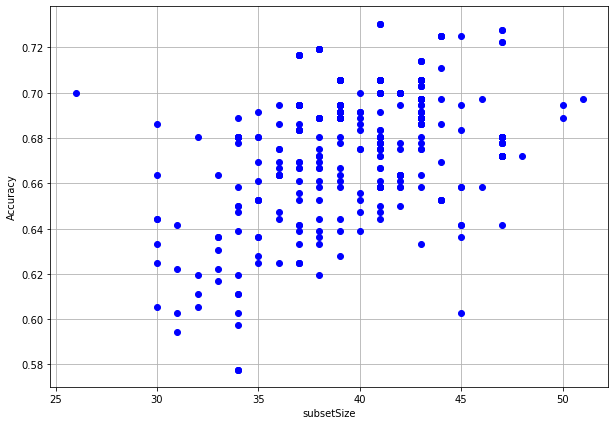

In [11]:
import matplotlib.pyplot as plt #MatPlotLib usado para desenhar o gráfico criado com o NetworkX

#iterations = list(range(1,len(optimizer.get_cost_history)+1))
plt.figure(figsize=(10,7))
#plt.xlabel('2^i classes')
plt.xlabel('subsetSize')
plt.ylabel('Accuracy')
plt.plot(particleSize, particleScore, 'bo')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)


#plt.savefig("D:/USP/2018-1/Computação Bioinspirada/Trabalhos/iterationVSerrorRate2.png", format="PNG")


plt.show()

In [12]:
from sklearn.model_selection import cross_val_score
# Create two instances of LogisticRegression
classfier = linear_model.LogisticRegression()
# classifier = RandomForestClassifier(n_estimators = 64,
#                                     # max_features = 30,
#                                     bootstrap = True,
#                                     random_state = None)

rank = list()

fullSet = cross_val_score(classifier, X, y, cv=5)
print("Full set Accuracy: %0.2f (+/- %0.2f)" % (fullSet.mean(), fullSet.std() * 2))
print("----------------------------------------------------------------------------")
bests = optimizer.swarm.pbest_pos #optimizer.get_pos_history
for b in bests:
    # Get the selected features from the final positions
    X_selected_features = X[:,b==1]  # subset

    # Perform classification and store performance in P
    #classifier.fit(X_selected_features, y)
    scores = cross_val_score(classifier, X_selected_features, y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), b)
    rank.append([scores.mean(), b])
    # Compute performance
    #subset_performance = (c1.predict(X_selected_features) == y).mean()
    #subset_performance = (classifier.predict(X_selected_features) == y).mean()
    

    #print('Subset performance: %.3f' % (subset_performance))

Full set Accuracy: 0.78 (+/- 0.08)
----------------------------------------------------------------------------
Accuracy: 0.74 (+/- 0.08) [1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0
 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1
 1 0 1 1 1 0]
Accuracy: 0.73 (+/- 0.06) [1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1
 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0
 0 1 0 0 0 0]
Accuracy: 0.74 (+/- 0.07) [0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 1]
Accuracy: 0.71 (+/- 0.06) [0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1
 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1
 1 1 0 0 1 1]
Accuracy: 0.70 (+/- 0.10) [1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 0 1 1 0 0 

In [13]:
rank = np.array(rank)

fullSetAccuracy = round(fullSet.mean(),4)
bestSubsetAccuracy = round(max(rank[:,0]),4)

for i in range(len(rank)):
  if rank[i, 0] == max(rank[:,0]):
    bestSubsetLength = sum(rank[i, 1])

print("Full set accuracy:", fullSetAccuracy)
print("Best subset accuracy:", bestSubsetAccuracy)
print("Best subset length:", bestSubsetLength)
print("-----------------------------------------------")
print("-----------------------------------------------")
print("             length  |  accuracy")
print("full set     ", X.shape[1], "      ", fullSetAccuracy)
print("best subset  ", bestSubsetLength, "      ", bestSubsetAccuracy)

Full set accuracy: 0.775
Best subset accuracy: 0.7444
Best subset length: 47
-----------------------------------------------
-----------------------------------------------
             length  |  accuracy
full set      80        0.775
best subset   47        0.7444


<ipython-input-13-015504dc16ce>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rank = np.array(rank)
